In [1]:
%%capture

!pip install spacy
!pip install corus
!pip install num2words
!pip install -q fasttext

In [2]:
%%capture

import spacy
import pandas as pd
from corus import load_lenta2
from tqdm import tqdm
from numpy.linalg import norm
import numpy as np
from sklearn.base import BaseEstimator

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import re
import string
import nltk
from num2words import num2words
from scipy.spatial.distance import cosine
from sklearn.model_selection import GridSearchCV
import random

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
import fasttext

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_res = pd.read_excel('/content/drive/MyDrive/vacancy_datasets/resume_train.xlsx')

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/vacancy_datasets/it_resume.csv')

In [ ]:
job = pd.read_excel('/content/drive/MyDrive/vacancy_datasets/vacancies.xlsx')

In [ ]:
job_train = pd.read_excel('/content/drive/MyDrive/vacancy_datasets/vacancy_train.xlsx')

#Подготовка тренировочных данных

Подготовим тренировочные данные по вакансиям на русском:

Объединим софт и хард скиллы в один столбец:

In [ ]:
job_train['skills'] = ''

for row in range(len(job_train)):

  for i in range(0, len(job_train['hardSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')), 3):
    job_train['skills'][row] = job_train['skills'][row] + ' ' + job_train['hardSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')[i][job_train['hardSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')[i].find('hard_skill_name') + 16:]

  for i in range(1, len(job_train['softSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')), 3):
    job_train['skills'][row] = job_train['skills'][row] + ' ' + job_train['softSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')[i][job_train['softSkills'][row].replace("[", "").replace("]", "").replace("{", "").replace("}", "").replace('"', "").split(',')[i].find('soft_skill_name') + 16:]

In [ ]:
job_train[(job_train['hardSkills'] != '[]') & (job_train['softSkills'] != '[]')][['hardSkills', 'softSkills', 'skills']].iloc[0]

hardSkills    [{"hard_skill_name":"владение компьютером на у...
softSkills    [{"owner_id":"2aee956e-562d-11ee-8e88-9586bb63...
skills         владение компьютером на уровне уверенного пол...
Name: 11, dtype: object

In [ ]:
job_train_filter = job_train.drop(['hardSkills', 'softSkills', 'professionalSphereName', 'code_professional_sphere'], axis=1).fillna('')

In [ ]:
job_train_filter

,additional_requirements,position_requirements,position_responsibilities,vacancy_name,skills
0,,1. Опыт работы в бюджетном учреждении (медици...,1.Ведение бухгалтерского учета на участках ;У...,Бухгалтер,
1,,"Знание ПК, ворд, ехл, эл. почта.",В бухгалтерскую фирму требуется Помощник бухг...,бухгалтер,
2,,"знание 1С, налогового кодекса, владение прогр...",Ведение бухгалтерской отчетности,Бухгалтер,
3,"Официальное оформление, трудовой договор Режи...",Высокий уровень владения и умения применять з...,"Работа с системой ""Клиент-Банк"" (рублевые и в...",Бухгалтер-экономист,бухгалтерский учет excel валютные операции
4,"0,25 ставки","Ответственность, коммуникабельность, умение р...","Сдача отчетности в архив, прием и отправка ко...",Делопроизводитель,
...,...,...,...,...,...
68448,,Грузчик должен знать: правила погрузки и выгр...,"Погрузка, выгрузка и внутрискладская перерабо...",Грузчик,
68449,,На должность механика по ремонту оборудования...,"Знать устройство, технические характеристики ...",механик по ремонту оборудования,
68450,Условия: работа на территории работодат...,Навыки чтения принципиальных схем и схем со...,Выполнение электромонтажных работ (вторичн...,Электромонтажник вторичных цепей,
68451,,"Среднее техническое образование, стаж работы ...",Выполнение работ по технической эксплуатации ...,Электромонтер стационарного радиооборудования ...,


In [ ]:
%%capture

job_train_filter['full_text'] = ''

columns = ['vacancy_name', 'additional_requirements', 'position_requirements', 'position_responsibilities', 'skills']

for i in tqdm(range(len(job_train_filter))):
    for col in columns:
        job_train_filter['full_text'][i] = job_train_filter['full_text'][i] + ' ' + str(job_train_filter[col][i])

Очистим данные:

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
job_train_filter['full_text'] = job_train_filter['full_text'].apply(lambda x: ' '.join(token.lemma_.lower() for token in nlp(x) if
        not token.is_punct # удаление пунктуации
        and not token.is_digit # удаление цифр
        and not token.like_num # удаление чисел, в том числе в виде текста
        and not token.is_space # удаление пробельных символов
    )
)

In [ ]:
def tokenize(text):
	tokens = re.split(r'\W+', text)
	return tokens

stops = nltk.corpus.stopwords.words("russian")
bad_words = ['родился', 'родилась', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь',
              'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']

wnl = WordNetLemmatizer()
def removeStopWords(text):
	text = [wnl.lemmatize(word) for word in text if (word not in stops) & (word not in bad_words)]
	return text

In [ ]:
job_train_filter['full_text'] = job_train_filter['full_text'].apply(lambda x: tokenize(x))
job_train_filter['full_text'] = job_train_filter['full_text'].apply(lambda x: removeStopWords(x))
job_train_filter['join_full_text'] = job_train_filter['full_text'].apply(lambda x: ' '.join(x))

In [ ]:
job_train_filter.to_csv('/content/job_train_filter.csv')

Подготовим тренировочные данные по резюме на русском:

In [ ]:
train_res['full_text'] = train_res['Resume_text'].apply(lambda x: ' '.join(token.lemma_.lower() for token in nlp(x) if
        not token.is_punct # удаление пунктуации
        and not token.is_digit # удаление цифр
        and not token.like_num # удаление чисел, в том числе в виде текста
        and not token.is_space # удаление пробельных символов
    )
)

In [ ]:
train_res['full_text'] = train_res['full_text'].apply(lambda x: tokenize(x))
train_res['full_text'] = train_res['full_text'].apply(lambda x: removeStopWords(x))
train_res['join_full_text'] = train_res['full_text'].apply(lambda x: ' '.join(x))

In [18]:
train_res['join_full_text'] = train_res['full_text'].apply(lambda x: ''.join(x))
job_train_filter['join_full_text'] = job_train_filter['full_text'].apply(lambda x: ''.join(x))

In [ ]:
train_res.to_csv('/content/train_res.csv')

Соединим данные для обучения

In [5]:
# job_train_filter = pd.read_csv('/content/job_train_filter.csv')

In [6]:
# train_res = pd.read_csv('/content/train_res.csv')

In [19]:
train_res

,Unnamed: 0,Resume_text,full_text,join_full_text
0,0,DESIGNER Summary Designer with more than 15 y...,"['designer', 'summary', 'designer', 'year', 'p...","['designer', 'summary', 'designer', 'year', 'p..."
1,1,DESIGNER Summary Established well-rounded Des...,"['designer', 'summary', 'establish', 'well', '...","['designer', 'summary', 'establish', 'well', '..."
2,2,DESIGNER Summary To get a strong foothold on ...,"['designer', 'summary', 'get', 'strong', 'foot...","['designer', 'summary', 'get', 'strong', 'foot..."
3,3,DESIGNER / TECHNICAL DESIGNER Summary Creativ...,"['designer', 'technical', 'designer', 'summary...","['designer', 'technical', 'designer', 'summary..."
4,4,MULTIMEDIA DESIGNER AND GRAPHIC DESIGNER Port...,"['multimedia', 'designer', 'graphic', 'designe...","['multimedia', 'designer', 'graphic', 'designe..."
...,...,...,...,...
567,567,PHYSICAL THERAPIST TECHNICIAN Education Glenc...,"['physical', 'therapist', 'technician', 'educa...","['physical', 'therapist', 'technician', 'educa..."
568,568,ADMINISTRATIVE ASSISTANT Professional Summary...,"['administrative', 'assistant', 'professional'...","['administrative', 'assistant', 'professional'..."
569,569,CONCRETE LABORER/FINISHER/OPERATOR Profession...,"['concrete', 'laborer', 'finisher', 'operator'...","['concrete', 'laborer', 'finisher', 'operator'..."
570,570,HYDROBLASTING TECHNICIAN 1 Career Objective A...,"['hydroblasting', 'technician', 'career', 'obj...","['hydroblasting', 'technician', 'career', 'obj..."


In [21]:
all_data_train = pd.concat([train_res['join_full_text'], job_train_filter['join_full_text']], axis=0, ignore_index=True)

In [ ]:
tagged_data = [TaggedDocument(words=text.lower().split(), tags=[f"doc_{idx}"]) for idx, text in enumerate(all_data_train)]

In [22]:
all_data_train

0        ['designer', 'summary', 'designer', 'year', 'p...
1        ['designer', 'summary', 'establish', 'well', '...
2        ['designer', 'summary', 'get', 'strong', 'foot...
3        ['designer', 'technical', 'designer', 'summary...
4        ['multimedia', 'designer', 'graphic', 'designe...
                               ...                        
69020    ['грузчик', 'грузчик', 'должен', 'знать', 'пра...
69021    ['механик', 'ремонту', 'оборудования', 'должно...
69022    ['электромонтажник', 'вторичных', 'цепей', 'ус...
69023    ['электромонтер', 'стационарного', 'радиообору...
69024    ['продавец', 'продовольственных', 'товаров', '...
Name: join_full_text, Length: 69025, dtype: object

# Подготовка датасета с резюме

In [ ]:
res.drop(['Unnamed: 0', 'Обновление резюме', 'Авто', 'index_prog'], axis=1, inplace=True)

Сделаем некоторую предобработку: выделим из столбцов признаки, поменяет ЗП в валюте в рубли, полный адрес заменим на город

In [ ]:
%%capture

res['move'] = 0

for row in range(res.shape[0]):
  if ('не готова к переезду' in res['Город, переезд, командировки'][row]) | ('не готов к переезду' in res['Город, переезд, командировки'][row]):
    res['move'].loc[row] = 0
  else:
    res['move'].loc[row] = 1

res['currency'] = res['ЗП'].apply(lambda x: x[x.find(' ') + 1:])
res['ЗП'] = res['ЗП'].apply(lambda x: x[:x.find(' ')])

if res['currency'][row] == 'USD':
    res['ЗП'][row] = int(res['ЗП'][row]) * 88

if res['currency'][row] == 'KZT':
    res['ЗП'][row] = int(res['ЗП'][row]) * 0.2

if res['currency'][row] == 'бел.руб.':
    res['ЗП'][row] = int(res['ЗП'][row]) * 28

res = res[(res['currency'] == 'руб.') | (res['currency'] == 'USD') | (res['currency'] == 'KZT') | (res['currency'] == 'бел.руб.')]
res.drop('currency', axis = 1, inplace=True)



In [ ]:
res.reset_index(inplace=True, drop=True)

In [ ]:
for row in range(res.shape[0]):
  res['ЗП'][row] = int(res['ЗП'][row])

In [ ]:
%%capture

res['Город, переезд, командировки'] = res['Город, переезд, командировки'].apply(lambda x: x[:x.find(' ')])
res['Образование и ВУЗ'] = res['Образование и ВУЗ'].apply(lambda x: x[:x.find('образование') + 11])

Разделим резюме по категориям, в зависимости от ожидаемой ЗП:

In [ ]:
res['category'] = 0

res.loc[res['ЗП'] < 40000, 'category'] = 1
res.loc[(res['ЗП'] >= 40000) & (res['ЗП'] < 60000), 'category'] = 2
res.loc[(res['ЗП'] >= 60000) & (res['ЗП'] < 100000), 'category'] = 3
res.loc[(res['ЗП'] >= 100000) & (res['ЗП'] < 150000), 'category'] = 4
res.loc[(res['ЗП'] >= 150000) & (res['ЗП'] < 200000), 'category'] = 5
res.loc[(res['ЗП'] >= 200000) & (res['ЗП'] < 300000), 'category'] = 6
res.loc[res['ЗП'] >= 300000, 'category'] = 7

In [ ]:
res['category'].value_counts()

3    2358
1    1939
2    1805
4    1783
5    1076
6     748
7     215
Name: category, dtype: int64

Создадим столбец для хранения текстовой информации и последующей предобработки:

In [ ]:
%%capture

res['full_text'] = ''

columns = ['Ищет работу на должность:', 'Занятость', 'График', 'Опыт работы', 'Последняя/нынешняя должность',
       'Образование и ВУЗ']

for i in tqdm(range(len(res))):
    for col in columns:
        res['full_text'][i] = res['full_text'][i] + ' ' + str(res[col][i])

In [ ]:
res['full_text'][0]

' веб разработчик html css js php базы данных фреймворки дизайн интерфейсы cms частичная занятость, проектная работа, полная занятость гибкий график, удаленная работа Опыт работы 18 лет 9 месяцев  Август 2017 — Апрель  2019 1 год 9 месяцев OpenSoft Саратов , www.opensoftdev.ru Информационные технологии, системная интеграция, интернет ... Системная интеграция, автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг Инженер-программист Разработка и поддержка сайтов на корпоративной CMS и на WordPress; разработка корпоративной CMS; дизайн, вёрстка, улучшение интерфейсов существующих сайтов, основанных на разных фреймворках и CMS; консультации и техническая поддержка.  Октябрь 2006 — Июнь  2018 11 лет 9 месяцев СГУ им. Н.Г. Чернышевского Саратовская область , www.sgu.ru/ Преподаватель, научный руководитель Преподаватель (растровая компьютерная графика, разработка интерфейсов, PHP, JavaScript, фотография и др. дисциплины)  Июнь 2013 — Сентябрь  2017 4 года 4 месяца MIF T

Очистим данные:

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
res['full_text'] = res['full_text'].apply(lambda x: ' '.join(token.lemma_.lower() for token in nlp(x) if
        not token.is_punct # удаление пунктуации
        and not token.is_digit # удаление цифр
        and not token.like_num # удаление чисел, в том числе в виде текста
        and not token.is_space # удаление пробельных символов
        and not token.like_url
    )
)

In [ ]:
res['full_text'] = res['full_text'].apply(lambda x: tokenize(x))
res['full_text'] = res['full_text'].apply(lambda x: removeStopWords(x))
res['full_text'] = res['full_text'].apply(lambda x: ' '.join(x))

In [ ]:
res['full_text'][2257]

'php разработчик javascript разработчик частичная занятость проектная работа полная занятость гибкий график полный день удаленная работа опыт работы года месяцев php разработчик javascript разработчик руб информационные технологии интернет телеком программирование разработка занятость частичная занятость проектная работа полная занятость график работы гибкий график полный день удаленная работа опыт работы года месяцев месяца the big d уфа backend разработчик удаленно backend месяцев the big d уфа backend разработчик backend месяца webhand москва информационные технологии системная интеграция интернет интернет компания поисковики платежные системы информационно познавательные развлекательные ресурсы продвижение сайтов прочее разработка программного обеспечения backend разработчик удаленно доработка поддерживаемых проектов месяцев startkomp уфа full stack разработчик разработка узкопрофильных веб приложений поддержка существующих проектов месяцев веб студия smarty дюртюли информационные 

In [ ]:
res.to_csv('/content/res.csv')

# Подготовка датасета с вакансиями

In [ ]:
job.drop(['vac_title_tag', 'link'], axis=1, inplace=True)

In [ ]:
job.fillna('', inplace=True)

In [ ]:
job['salary'] = np.random.randint(30000, 350000, job.shape[0])

In [ ]:
job['category'] = 0

job.loc[job['salary'] < 40000, 'category'] = 1
job.loc[(job['salary'] >= 40000) & (job['salary'] < 60000), 'category'] = 2
job.loc[(job['salary'] >= 60000) & (job['salary'] < 100000), 'category'] = 3
job.loc[(job['salary'] >= 100000) & (job['salary'] < 150000), 'category'] = 4
job.loc[(job['salary'] >= 150000) & (job['salary'] < 200000), 'category'] = 5
job.loc[(job['salary'] >= 200000) & (job['salary'] < 300000), 'category'] = 6
job.loc[job['salary'] >= 300000, 'category'] = 7

In [ ]:
job['category'].value_counts()

6    1709
5     834
4     808
7     749
3     612
2     357
1     166
Name: category, dtype: int64

In [ ]:
job['address'] = job['address'].apply(lambda x: x[:x.find(',')] if(x.find(',') != -1) else x)

In [ ]:
job.head(10)

,vacancy_title,required_experience,description,skills,address,mode,salary,category
0,.Net back-end developer (remote),3–6 лет,Velvetech is an American global software devel...,"ASP.NET, MS SQL Server, C#",Алматы,"Полная занятость, удаленная работа",32386,1
1,.Net back-end developer (remote),3–6 лет,Velvetech is an American global software devel...,"ASP.NET, MS SQL Server, C#",Баку,"Полная занятость, удаленная работа",217749,6
2,.Net back-end developer (remote),3–6 лет,Velvetech is an American global software devel...,"ASP.NET, MS SQL Server, C#",Тбилиси,"Полная занятость, удаленная работа",221834,6
3,.NET разработчик,1–3 года,Привет! На связи deeplay — продуктовая IT-комп...,".NET Framework, C#, .NET Core, Git, ООП",Москва,"Полная занятость, удаленная работа",131283,4
4,.NET разработчик,1–3 года,Привет! На связи deeplay — продуктовая IT-комп...,".NET Framework, C#, .NET Core, Git, ООП",Новосибирск,"Полная занятость, удаленная работа",72907,3
5,".NET Разработчик (Web, .Net Core)",1–3 года,"IT-Aces - Аккредитованная IT Компания, все льг...",,Ярославль,"Полная занятость, удаленная работа",184362,5
6,.NET разработчик (удалёнка),3–6 лет,NEXTEPIC - Объединяем профессионалов. Помогаем...,".NET Core, С#, SQL, Git, реляционные CУБД, инт...",Санкт-Петербург,"Полная занятость, удаленная работа",77103,3
7,1C Developer Trainee,не требуется,Покоряйте вершины с Aston! IT-компания ASTON ...,"1С: Предприятие 8, ERP-системы на базе 1С, сам...",Санкт-Петербург,"Стажировка, полный день",84142,3
8,2D Artist,1–3 года,"Чем предстоит заниматься: Отрисовка иконок, пр...","Adobe Photoshop, Figma, Stable Diffusion, Arti...",Санкт-Петербург,"Полная занятость, полный день",41240,2
9,2d Художник,3–6 лет,"Октавиан Гейм Арт — это российская компания, с...","Adobe Photoshop, Креативность, Дизайн",Санкт-Петербург,"Полная занятость, полный день",80241,3


Сделаем колонку, где текстом будут записаны все данные

In [ ]:
job['full_text'] = ''

In [ ]:
job.columns

Index(['vacancy_title', 'required_experience', 'description', 'skills',
       'address', 'mode', 'salary', 'category', 'full_text'],
      dtype='object')

In [ ]:
columns = ['vacancy_title', 'description', 'skills', 'mode']

In [ ]:
for i in tqdm(range(len(job))):
    for col in columns:
        job['full_text'][i] = job['full_text'][i] + ' ' + str(job[col][i])

  0%|          | 0/5235 [00:00<?, ?it/s]<ipython-input-82-467c138444d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job['full_text'][i] = job['full_text'][i] + ' ' + str(job[col][i])
100%|██████████| 5235/5235 [00:07<00:00, 709.61it/s]


Очистка:

In [ ]:
job['full_text'] = job['full_text'].apply(lambda x: ' '.join(token.lemma_.lower() for token in nlp(x) if
        not token.is_punct # удаление пунктуации
        and not token.is_digit # удаление цифр
        and not token.like_num # удаление чисел, в том числе в виде текста
        and not token.is_space # удаление пробельных символов
        and not token.like_url
    )
)

In [ ]:
job['full_text'] = job['full_text'].apply(lambda x: tokenize(x))
job['full_text'] = job['full_text'].apply(lambda x: removeStopWords(x))
job['full_text'] = job['full_text'].apply(lambda x: ' '.join(x))

In [ ]:
job['full_text'][0]

' net back end developer remote velvetech be an american global software development company headquarter in chicago il velvetech have it developer strategically distribute in global technical job market to deliver the good in class software engineering and exceptional client service we have year of experience in software and hardware development for client all around the world especially for u client a an official microsoft gold partner our company be list in the top software development company in illinois usa usclient be lead trading and financial organization insurance company large healthcare association pharmaceutical and energy company equipment manufacturer hi tech startup etc area of expertise be consult development implementation and support of software solution we implement modern backend solution that support microservice architecture with the follow technology net core java sql server postgresql mongodb redis rabbitmq for the web ui front end development we opt for react or

In [ ]:
job.to_csv('/content/job.csv')

#Обучаем модель:

In [ ]:
%%time

model = Doc2Vec(vector_size=300, window=3, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)

for epoch in tqdm(range(model.epochs), desc="Training Doc2Vec"):
  model.train(tagged_data, total_examples=model.corpus_count, epochs=1)

Training Doc2Vec: 100%|██████████| 20/20 [07:52<00:00, 23.60s/it]

CPU times: user 10min 49s, sys: 22.4 s, total: 11min 11s
Wall time: 7min 58s


Получим векторы для резюме:

In [ ]:
res['vector'] = ''

for i in tqdm(range(len(res))):
  resume_vector = model.infer_vector(res['full_text'][i].split())
  res['vector'][i] = resume_vector

<ipython-input-130-55ba2e927ef2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['vector'] = ''
  0%|          | 0/9924 [00:00<?, ?it/s]<ipython-input-130-55ba2e927ef2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['vector'][i] = resume_vector
100%|██████████| 9924/9924 [00:34<00:00, 287.86it/s]


А так же для вакансий:

In [ ]:
job['vector'] = ''

for i in tqdm(range(len(job))):
  job_vector = model.infer_vector(job['full_text'][i].split())
  job['vector'][i] = job_vector

  0%|          | 0/5235 [00:00<?, ?it/s]<ipython-input-132-9e9a092863e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job['vector'][i] = job_vector
100%|██████████| 5235/5235 [00:11<00:00, 471.95it/s]


In [ ]:
res.to_csv('/content/resume_vectors_final.csv')

In [ ]:
job.to_csv('/content/job_vectors_final.csv')

# Ранжирование

Модель Doc2Vec: vector_size=300, window=3, min_count=1, workers=4, epochs=20

In [ ]:
n = 6780

test_resume = res.iloc[n]['vector']
res.iloc[n]['Ищет работу на должность:']

'инженер программист'

In [ ]:
job['similarity_score'] = job['vector'].apply(lambda x: 1 - cosine(x, test_resume))

In [ ]:
job.sort_values(['similarity_score'], ascending=False)[:3]['vacancy_title'].to_list()

['Системный аналитик/исследователь',
 'System Analyst Jun+/Middle',
 'Разработчик (middle)']

Модель Doc2Vec: vector_size=500, window=5, min_count=3, workers=4, epochs=20

In [ ]:
%%time

model_1 = Doc2Vec(vector_size=500, window=5, min_count=3, workers=4, epochs=20)
model_1.build_vocab(tagged_data)

for epoch in tqdm(range(model_1.epochs), desc="Training Doc2Vec"):
  model_1.train(tagged_data, total_examples=model_1.corpus_count, epochs=1)

Training Doc2Vec: 100%|██████████| 20/20 [09:12<00:00, 27.61s/it]

CPU times: user 13min 22s, sys: 19.4 s, total: 13min 41s
Wall time: 9min 15s


In [ ]:
res['vector'] = ''

for i in tqdm(range(len(res))):
  resume_vector = model.infer_vector(res['full_text'][i].split())
  res['vector'][i] = resume_vector

job['vector'] = ''

for i in tqdm(range(len(job))):
  job_vector = model.infer_vector(job['full_text'][i].split())
  job['vector'][i] = job_vector

100%|██████████| 5235/5235 [00:10<00:00, 516.94it/s]


In [ ]:
n = 6780

test_resume = res.iloc[n]['vector']
res.iloc[n]['Ищет работу на должность:']

'инженер программист'

In [ ]:
job['similarity_score'] = job['vector'].apply(lambda x: 1 - cosine(x, test_resume))

In [ ]:
job.sort_values(['similarity_score'], ascending=False)[:3]['vacancy_title'].to_list()

['Системный аналитик/исследователь',
 'System Analyst Jun+/Middle',
 'Разработчик (middle)']

Модель Doc2Vec: vector_size=500, window=5, min_count=3, workers=4, epochs=20

In [ ]:
%%time

model_3 = Doc2Vec(vector_size=1000, window=5, min_count=3, workers=4, epochs=20)
model_3.build_vocab(tagged_data)

for epoch in tqdm(range(model_3.epochs), desc="Training Doc2Vec"):
  model_3.train(tagged_data, total_examples=model_3.corpus_count, epochs=1)

Training Doc2Vec: 100%|██████████| 20/20 [12:17<00:00, 36.86s/it]

CPU times: user 18min 57s, sys: 19.3 s, total: 19min 16s
Wall time: 12min 20s


In [ ]:
res['vector'] = ''

for i in tqdm(range(len(res))):
  resume_vector = model.infer_vector(res['full_text'][i].split())
  res['vector'][i] = resume_vector

job['vector'] = ''

for i in tqdm(range(len(job))):
  job_vector = model.infer_vector(job['full_text'][i].split())
  job['vector'][i] = job_vector

100%|██████████| 5235/5235 [00:10<00:00, 509.76it/s]


In [ ]:
n = 999

test_resume = res.iloc[n]['vector']
res.iloc[n]['Ищет работу на должность:']

'frontend разработчик'

In [ ]:
job['similarity_score'] = job['vector'].apply(lambda x: cosine(x, test_resume))

In [ ]:
job.sort_values(['similarity_score'], ascending=False)[:3]['vacancy_title'].to_list()

['Middle frontend-разработчик (VUE)',
 'Senior-frontend developer',
 'Frontend-разработчик (React)']

Возьмем визуально лучшую модель и попробуем получить рекомендации для всех резюме:

Выдаем вакансиям id:

In [ ]:
job['id'] = 0

for i in tqdm(range(len(job))):
  job['id'][i] = i

100%|██████████| 5235/5235 [00:01<00:00, 2771.55it/s]


In [ ]:
res['id'] = 0

for i in tqdm(range(len(res))):
  res['id'][i] = i

100%|██████████| 9924/9924 [00:05<00:00, 1974.49it/s]


Найдем для каждого резюме три релевантные вакансии. Предварительно будем делать фильтрацию по зарплатной категории и городу.

In [ ]:
res.reset_index(inplace=True, drop=True)
job.reset_index(inplace=True, drop=True)

In [ ]:
res[['vac1', 'vac2', 'vac3']] = ''

for i in tqdm(range(len(res))):

  if res.iloc[i]['move'] == 0: # если переезд невозможен, смотрим только на вакансии в городе проживания
    data_for_match = job[(job['address'] == res.iloc[i]['Город, переезд, командировки']) & (job['category'] == res.iloc[i]['category'])] # также просматриваем вакансии только в подходящей зарплатной категории
    if len(data_for_match) < 3:
      data_for_match = job[(job['address'] == res.iloc[i]['Город, переезд, командировки'])] # если имеем меньше трех релевантных вакансий по данным фильтрам, ищем в той же локации, но с любой зарплатой
    if len(data_for_match) < 3:
      data_for_match = job
  else:
    data_for_match = job[(job['category'] == res.iloc[i]['category'])] # если переезд возможен, то не обращаем внимания на город
    if len(data_for_match) < 3:
      data_for_match = job # если имеем меньше трех релевантных вакансий по данным фильтрам, ищем с любой зарплатой

  resume_vec = res.iloc[i]['vector'] # получим вектор текущего резуме

  for j in range(len(data_for_match)):
    similarity_score = cosine(resume_vec, data_for_match.iloc[j]['vector']) # для каждой из отфильтрованных вакансий ищем косинусное сходство с текущим резюме
    data_for_match['similarity_score'][j] = similarity_score # записываем значение сходства для каждой вакансии

  data_for_match = data_for_match.sort_values(['similarity_score'], ascending=False)[:3] # сортируем по сходству и берем только 3 самых релевантных

  res['vac1'][i] = data_for_match.iloc[0]['id'] # в таблицу с резюме записываем id вакансий
  res['vac2'][i] = data_for_match.iloc[1]['id']
  res['vac3'][i] = data_for_match.iloc[2]['id']

100%|██████████| 9924/9924 [1:41:43<00:00,  1.63it/s]


Обработка 9924 резюме заняла 1:41, в итоге на одно резюме ушло 0.61 сек

In [ ]:
res[['id', 'vac1', 'vac2', 'vac3']]

,id,vac1,vac2,vac3
0,0,932,1467,1536
1,1,2398,2517,2493
2,2,1912,2195,2272
3,3,1634,1616,1626
4,4,2517,2493,1616
...,...,...,...,...
9919,9919,3725,1706,3719
9920,9920,4540,961,4136
9921,9921,3725,3231,3234
9922,9922,1912,1634,869


In [ ]:
res[['id', 'vac1', 'vac2', 'vac3']].to_csv('/content/resume_matching_final.csv', index=False)

#Обучим модель fasttext:

In [13]:
with open('data_full.txt', 'w') as f:
  for i in range(3000):
    f.write(''.join(all_data_train.iloc[i]))
    f.write(' ')

In [34]:
%%time

model_fasttext = fasttext.train_unsupervised('data_full_1.txt', model='skipgram', wordNgrams=3, dim=300, ws=3, minCount=1, epoch=20, thread=4, verbose=2)

CPU times: user 1h 40min 36s, sys: 18.9 s, total: 1h 40min 55s
Wall time: 57min 6s


In [38]:
res['vector_fasttext'] = res['full_text'].apply(lambda x: model_fasttext.get_sentence_vector(x))
job['vector_fasttext'] = job['full_text'].apply(lambda x: model_fasttext.get_sentence_vector(x))

In [133]:
n = 3

test_resume = res.iloc[n]['vector_fasttext']
res.iloc[n]['Ищет работу на должность:']

'ведущий программист 1c руководитель'

In [134]:
job['similarity_score_fasttext'] = job['vector_fasttext'].apply(lambda x: 1 - cosine(x, test_resume))

In [135]:
job.sort_values(['similarity_score_fasttext'], ascending=False)[:3]['vacancy_title'].to_list()

['Разработчик 1С', 'Программист 1С', 'Ведущий программист 1С']

Посмотрим схожесть названий вакансий и резюме:

In [67]:
res['vector_title_fasttext'] = res['Ищет работу на должность:'].apply(lambda x: model_fasttext.get_sentence_vector(x))
job['vector_title_fasttext'] = job['vacancy_title'].apply(lambda x: model_fasttext.get_sentence_vector(x))

In [105]:
n = 3978

test_resume = res.iloc[n]['vector_title_fasttext']
res.iloc[n]['Ищет работу на должность:']

'аналитик бизнес системный'

In [106]:
job['similarity_title_score_fasttext'] = job['vector_title_fasttext'].apply(lambda x: 1 - cosine(x, test_resume))

In [107]:
job.sort_values(['similarity_title_score_fasttext'], ascending=False)['vacancy_title'].unique()[:3]

array(['Бизнес / Системный аналитик', 'Системный/бизнес аналитик',
       'Системный аналитик\\ Бизнес аналитик'], dtype=object)

Модель fasttext работает хорошо, даже лучше Doc2Vec

Попробуем смотреть топ-3 по сумме косинусной схожести между названиями и описаниями:

In [143]:
n = 3

test_resume = res.iloc[n]['vector_fasttext']
test_resume_title = res.iloc[n]['vector_title_fasttext']
res.iloc[n]['Ищет работу на должность:']

'ведущий программист 1c руководитель'

In [144]:
job['similarity_score_fasttext'] = job['vector_fasttext'].apply(lambda x: 1 - cosine(x, test_resume))
job['similarity_title_score_fasttext'] = job['vector_title_fasttext'].apply(lambda x: 1 - cosine(x, test_resume_title))

In [145]:
job['sum_score'] = job['similarity_score_fasttext'] + job['similarity_title_score_fasttext']
job.sort_values(['sum_score'], ascending=False)[:3]['vacancy_title'].to_list()

['Ведущий инженер-программист',
 'Программист 1С/Ведущий специалист',
 'Ведущий инженер-программист']

Сделаем визуализацию названий:

In [198]:
two_dimensional_array = np.array(job['vector_title_fasttext'].apply(pd.Series))

In [199]:
# Применение t-SNE для снижения размерности
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(np.array(two_dimensional_array))

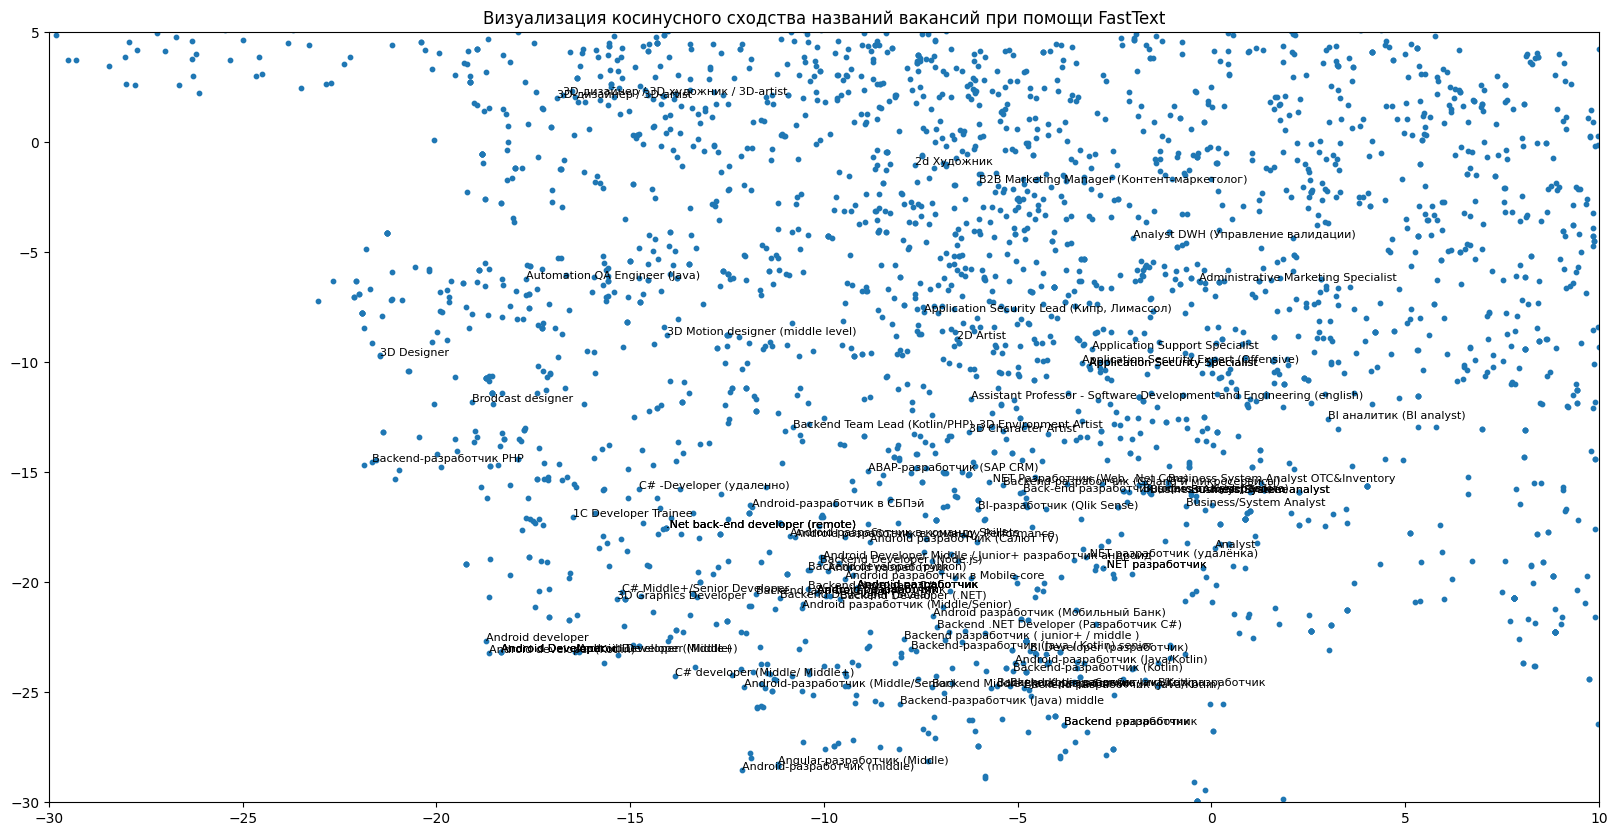

In [205]:
plt.figure(figsize=(20, 10))
plt.xlim(-30, 10)
plt.ylim(-30, 5)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)


for i, txt in enumerate(job['vacancy_title'][:100]):
    plt.annotate(txt, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=8)

plt.title("Визуализация косинусного сходства названий вакансий при помощи FastText")
plt.show()

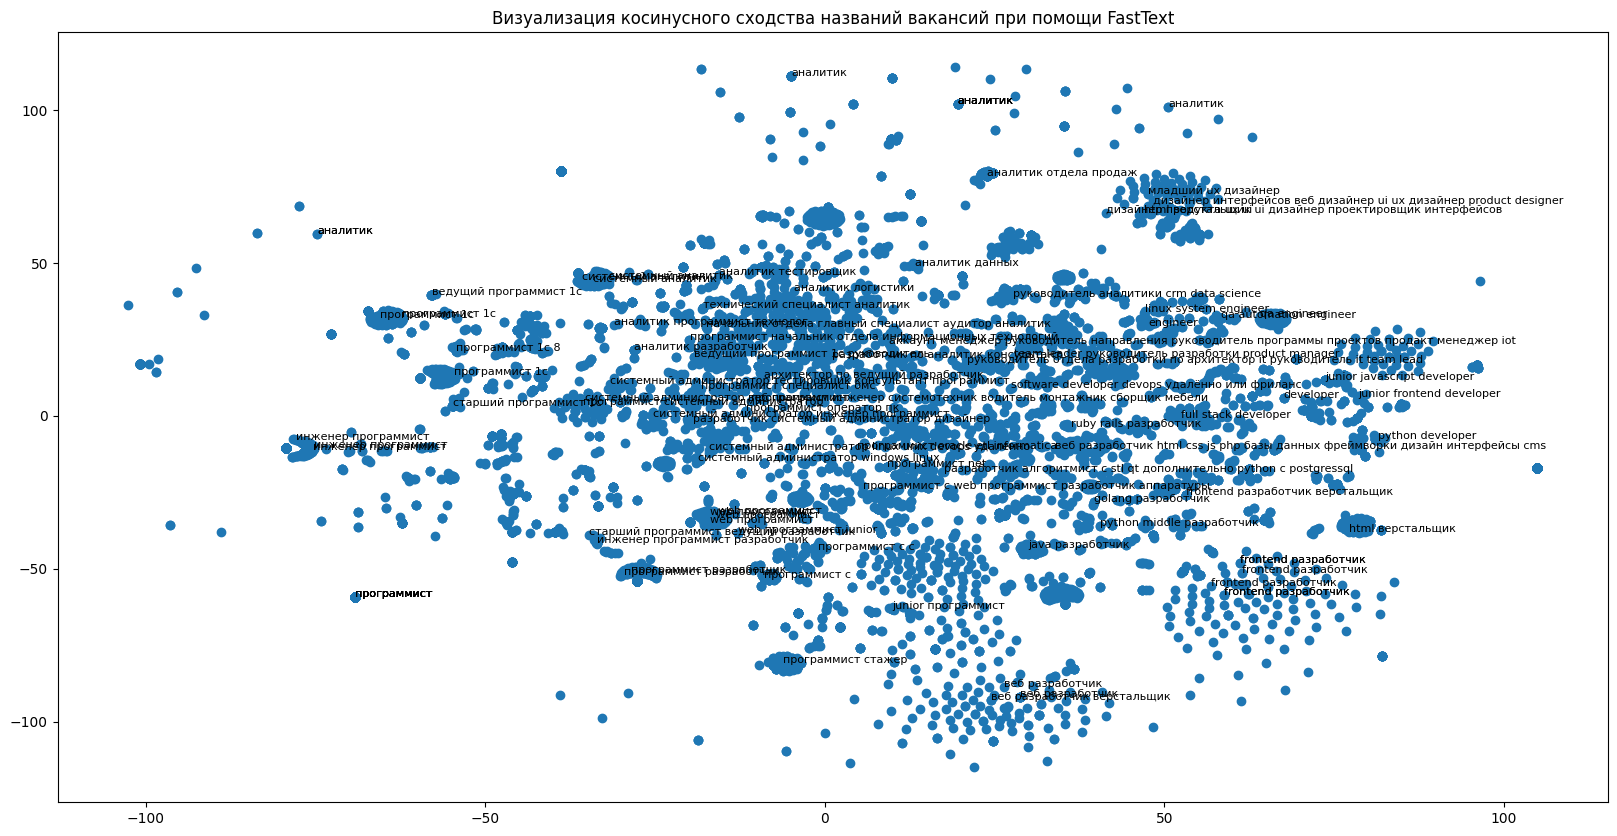

In [197]:
plt.figure(figsize=(20, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

for i, txt in enumerate(res['Ищет работу на должность:'][:100]):
    plt.annotate(txt, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=8)

plt.title("Визуализация косинусного сходства названий вакансий при помощи FastText")
plt.show()